In [50]:
import Pkg
Pkg.activate("packages")
using CSV, DataFrames, Plots, Plots.PlotMeasures, StatsPlots, Statistics

  Activating environment at `~/Documents/Still evolving/Quantifying-SIM/packages/Project.toml`


### Figure 2: Quantification of the accuray and precision of our inference method using simulated mutant count data

In [26]:
# Reading (true) input parameters
p = "range_mu-inc"
p2 = "range_switching"
true_para_1 = DataFrame(CSV.File("input_parameters/"*p*".csv"))
true_para_2 = DataFrame(CSV.File("input_parameters/"*p2*".csv"))
range_para_1 = collect(true_para_1.r_start[1]:true_para_1.r_increment[1]:true_para_1.r_end[1]) ./ true_para_1.divisions_off
J1 = length(range_para_1)
J2 = length(range_para_2)
range_para_2 = collect(true_para_2.r_start[1]:true_para_2.r_increment[1]:true_para_2.r_end[1]) ./ true_para_2.divisions_off
mu_off_true = true_para_1.mutations_off[1]
mu_on_true = mu_off_true * 10 .^ range_para_1
R = true_para_1.number_fluctuation_assays[1]
num_cultures = true_para_1.number_cultures[1];

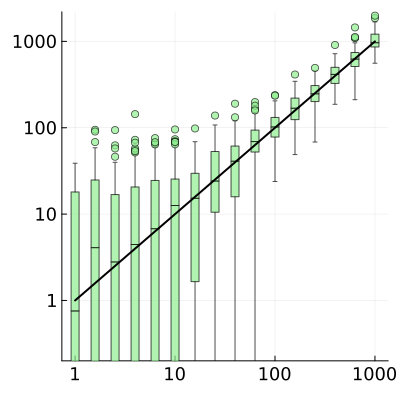

In [44]:
# Reading and plotting inferred parameters
# Estimation method heterogeneous-response, rel. division set to zero, known fraction
# Estimated compared to true mutation-rate increase for switching=0.01
m = "het_zero_div"
P_inc = plot(size=(400,400))
r = 11
for j1 = 1:2:J1
    inferred_para = DataFrame(CSV.File("inferred_parameters/"*p*"/switch_$r/"*m*"_$j1.csv"))
    boxplot!(P_inc, [j1], inferred_para.mutation_rate_on[(inferred_para.AIC .!= Inf)] ./ inferred_para.mutation_rate_off[(inferred_para.AIC .!= Inf)], lab="", c=:lightgreen, alpha=0.7)
end
plot!(P_inc, xticks=(collect(1:10:J1), Int.(10 .^ range_para_1[1:10:J1])), yticks=(Int.(10 .^ range_para_1[1:10:J1]), Int.(10 .^ range_para_1[1:10:J1])), yscale=:log10, ylim=(0.2, 2200), tickfontsize=12)
plot!(mu_on_true/mu_off_true, c=:black, width=2, lab="")
# Out comment the next line for labels
# plot!(ylab="Estimated mutation-rate increase", xlab="True mutation-rate increase", title="Relative switching rate = $(round(10^range_para_2[r], digits=3))")

In [46]:
savefig("figures/Figure_2A.pdf")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM/figures/Figure_2A.pdf"

In [54]:
# Determining numerical values for the precision
i = 21
inferred_para = DataFrame(CSV.File("inferred_parameters/"*p*"/switch_$r/"*m*"_$i.csv"))
println("Mutation-rate increase = ", (10 .^range_para_1)[i])
println("25 and 75 percent quantiles: ", quantile(inferred_para.mutation_rate_on[(inferred_para.AIC .!= Inf)] ./ inferred_para.mutation_rate_off[(inferred_para.AIC .!= Inf)], [0.25,0.75])/ (10 .^range_para_1)[i])

Mutation-rate increase = 100.0
25 and 75 percent quantiles: [0.7803450056982675, 1.3151145797549182]
